#Imports

In [1]:
from __future__ import print_function
from urllib.request import urlretrieve
from torch.utils.data import Dataset
from torch import optim

import os
import pickle as pkl
import numpy as np
import torch

import torch
import torch.utils.data

from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

import imageio
from datetime import datetime

from PIL import Image
import torchvision.transforms.functional as TF

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Parameters

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

pixels = 28
batch_size = 64
log_interval = 780
epochs = 30
bottleneck_dim = 32
use_conv = True
plot_images = True
plot_loss = True
save_images = False

root = os.getcwd()
print(f"Current working directory: {root}")

Current working directory: /content


# Load data

## MNIST binary

In [0]:
def load_mnist_binarized(root):
    datapath = os.path.join(root, 'bin-mnist')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    dataset = os.path.join(datapath, "mnist.pkl.gz")

    if not os.path.isfile(dataset):

        datafiles = {
            "train": "http://www.cs.toronto.edu/~larocheh/public/"
                     "datasets/binarized_mnist/binarized_mnist_train.amat",
            "valid": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                     "binarized_mnist/binarized_mnist_valid.amat",
            "test": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                    "binarized_mnist/binarized_mnist_test.amat"
        }
        datasplits = {}
        for split in datafiles.keys():
            print("Downloading %s data..." % (split))
            datasplits[split] = np.loadtxt(urlretrieve(datafiles[split])[0])

        pkl.dump([datasplits['train'], datasplits['valid'], datasplits['test']], open(dataset, "wb"))

    x_train, x_valid, x_test = pkl.load(open(dataset, "rb"))
    return x_train, x_valid, x_test


class BinMNIST(Dataset):
    """Binary MNIST dataset"""

    def __init__(self, data, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)


def get_binmnist_datasets(root, device='cpu'):
    x_train, x_valid, x_test = load_mnist_binarized(root)
    x_train = np.append(x_train, x_valid, axis=0)  # https://github.com/casperkaae/LVAE/blob/master/run_models.py (line 401)
    return BinMNIST(x_train, device=device), BinMNIST(x_test, device=device), BinMNIST(x_test, device=device)

In [0]:
# LOAD BINARY MNIST
x_train, x_valid, x_test = get_binmnist_datasets(root)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

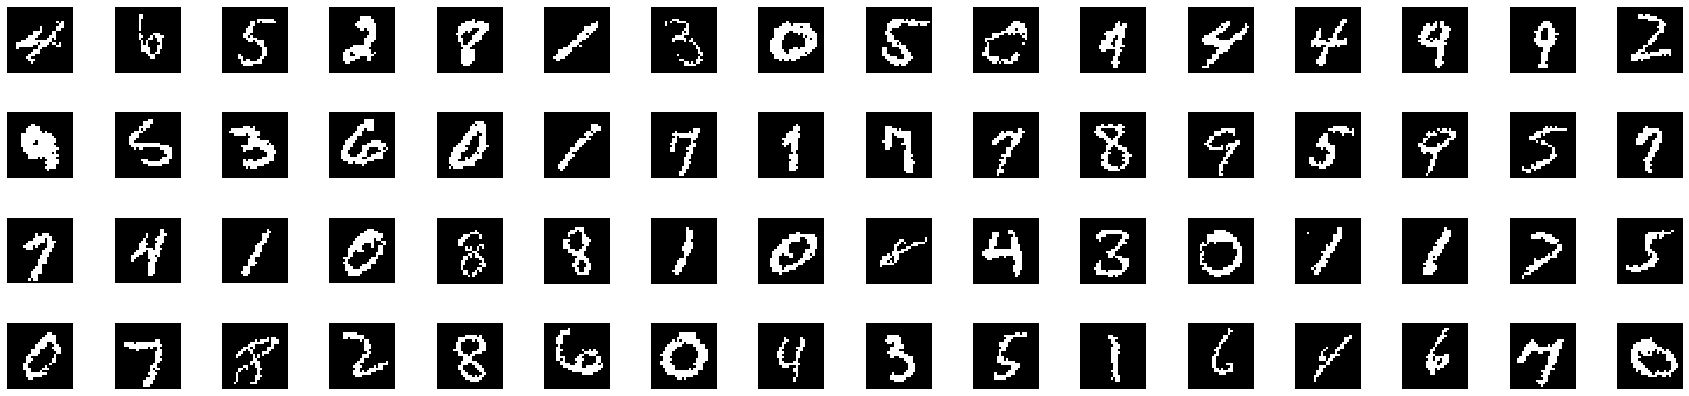

In [0]:
# Plot a few MNIST digit examples
f, axarr = plt.subplots(4, 16, figsize=(24, 6))
f.tight_layout()

# Load a batch of images into memory
images = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.show()

## Quick, Draw!

In [0]:
class Sketch(Dataset):
    """Sketch dataset"""

    def __init__(self, data, labels, device='cpu', transform=None):
        h, w, c = pixels, pixels, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
            label = self.transform(label)
        return sample, label


def convert_img2norm(img_list, ypixels, xpixels):
    norm_list = img_list.copy()
    norm_list = norm_list.astype('float32') / 255
    norm_list = np.reshape(norm_list, (len(norm_list), ypixels, xpixels, 1))
    
    return norm_list
    
    
def load_sketches(root):
    data_dir = "gdrive/My Drive/dataset"
    categories = ['bucket', 'apple', 'cloud', 'ice cream', 'butterfly', 'sheep', 'truck', 'pig', 't-shirt', 'basket']
    
    xpixels = pixels
    ypixels = pixels

    category_filenames = []
    for cat_name in categories:
        filename = os.path.join(data_dir, "full_numpy_bitmap_" + cat_name + ".npy")
        category_filenames.append(filename)

    n_take_train = 20000  # number of training images from each category
    n_take_test = 5000   # number of test images from each category
    
    # Load images
    n_categories = len(categories)  # number of classes

    # Training images and labels
    x_train = []
    y_train = []
    
    # Test images and labels
    x_test = []
    y_test = []  

    for i_category, category in enumerate(categories):
        data = np.load(category_filenames[i_category])
        n_data = len(data)
        
        print("[%d/%d] Reading category index %d: '%s' (%d images: take %d training, take %d test)" %
              (i_category+1, n_categories, i_category, category, n_data, n_take_train, n_take_test))

        for j, data_j in enumerate(data):
            img = np.array(data_j).reshape((ypixels, xpixels))
            img = np.invert(img)
            if j < n_take_train:   # append to training set
                x_train.append(img)
                y_train.append(i_category)  
            elif j - n_take_train < n_take_test: # append to test set
                x_test.append(img)
                y_test.append(i_category) 
            else:
                break

    # Convert to numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train) 
    x_test = np.array(x_test)
    y_test = np.array(y_test)  
    
    # Convert greyscale images to have values [0,1] and reshape to (n, ypixels, xpixels, 1)
    x_train = convert_img2norm(x_train, ypixels, xpixels)
    x_test = convert_img2norm(x_test, ypixels, xpixels)
    
    return Sketch(x_train, y_train, device=device), Sketch(x_test, y_test, device=device)

In [4]:
# LOAD QUICKDRAW (SKETCHES) DATASET
x_train, x_test = load_sketches(root)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

[1/10] Reading category index 0: 'bucket' (124064 images: take 20000 training, take 5000 test)
[2/10] Reading category index 1: 'apple' (144722 images: take 20000 training, take 5000 test)
[3/10] Reading category index 2: 'cloud' (120265 images: take 20000 training, take 5000 test)
[4/10] Reading category index 3: 'ice cream' (123133 images: take 20000 training, take 5000 test)
[5/10] Reading category index 4: 'butterfly' (117999 images: take 20000 training, take 5000 test)
[6/10] Reading category index 5: 'sheep' (126121 images: take 20000 training, take 5000 test)
[7/10] Reading category index 6: 'truck' (131354 images: take 20000 training, take 5000 test)
[8/10] Reading category index 7: 'pig' (186770 images: take 20000 training, take 5000 test)
[9/10] Reading category index 8: 't-shirt' (125233 images: take 20000 training, take 5000 test)
[10/10] Reading category index 9: 'basket' (118458 images: take 20000 training, take 5000 test)


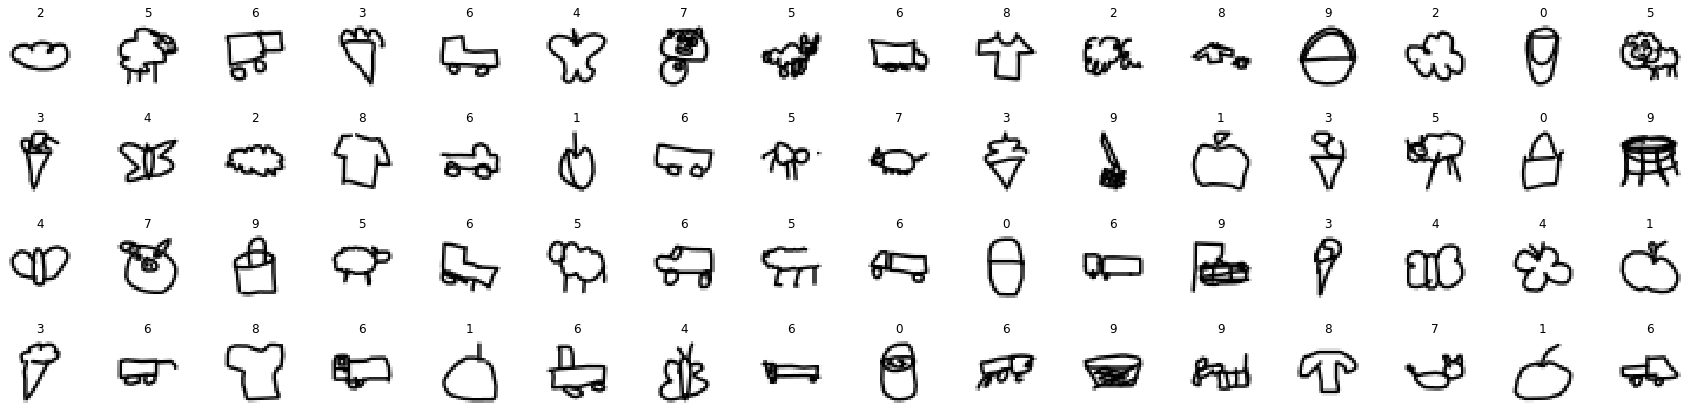

In [5]:
# Plot a few sketch examples
f, axarr = plt.subplots(4, 16, figsize=(24, 6))
f.tight_layout()

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.title.set_text(labels[i].item())
    ax.axis('off')
    
plt.show()

# VAE

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(pixels*pixels, 400)
        self.fc21 = nn.Linear(400, bottleneck_dim)
        self.fc22 = nn.Linear(400, bottleneck_dim)
        self.fc3 = nn.Linear(bottleneck_dim, 400)
        self.fc4 = nn.Linear(400, pixels*pixels)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, pixels*pixels))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE Conv

In [0]:
ngf = 64
ndf = 64
nc = 1
h_dim=1024

stride = 2
pad = 1
k_dim = 4

class conv_VAE(nn.Module):
    def __init__(self, nz=bottleneck_dim):
        super(conv_VAE, self).__init__()
        
        self.nz = nz
        
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, k_dim, stride, pad, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU(), # 
            
            # state size. (ndf) x 14 x 14 (25)
            nn.Conv2d(ndf, ndf * 2, k_dim, stride, pad, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU(), # 
            
            # state size. (ndf*2) x 7 x 7 (21)
            nn.Conv2d(ndf * 2, ndf * 4, k_dim-1, stride, pad, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU(), #
            
            # state size. (ndf*8) x 4 x 4 (14)
            nn.Conv2d(ndf * 4, 1024, k_dim, stride-1, pad-1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU() # 
        )
        
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(1024, ngf*8, k_dim, stride, pad-1, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True), # nn.ReLU(), # 
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, k_dim-1, stride, pad, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True), # nn.ReLU(), #
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*4, ngf*2, k_dim, stride, pad, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True), # nn.ReLU(), #
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf*2, nc, k_dim, stride, pad, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )
        
        self.fc1 = nn.Linear(h_dim, 512)
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.fc3 = nn.Linear(nz, 512)
        self.fc4 = nn.Linear(512, h_dim)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        
    def encode(self, x):
        conv = self.encoder(x);
        h1 = self.fc1(conv.view(-1, h_dim))
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        deconv_input = deconv_input.view(-1,h_dim,1,1)
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar

# Loss function

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, pixels*pixels), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), dim=1)

    return BCE + KLD, kl.mean()

# Train

In [0]:
def train(epoch):
    model.train()
    batch_loss, batch_kl = [],[]
    batch_idx = 0

    for data, _ in train_loader: # use with QUICK, DRAW! dataset
    # for data in train_loader:  # use with MNIST dataset
        data = data.to(device)

        recon_batch, mu, logvar = model(data)
        loss, kld = loss_function(recon_batch, data, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item() / len(data)) # divide by batch_size to get average
        batch_kl.append(kld.item())

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')   
        batch_idx = batch_idx + 1

    epoch_kl_train.append(np.mean(batch_kl))
    epoch_loss_train.append(np.mean(batch_loss))
    print(f'====> Epoch: {epoch} Average loss: {np.mean(batch_loss):.4f}')


# Test

In [0]:
def test(epoch):
    if epoch == 1:
        show_img = True
    else:
        show_img = True if epoch % 10 == 0 else False
        
    datapath = os.path.join(root, 'results')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    
    model.eval()
    batch_loss, batch_kl = [],[]
    
    with torch.no_grad():
        for data, _ in test_loader: # use with QUICK, DRAW! dataset
        # for data in test_loader:  # use with QUICK, DRAW! dataset
            data = data.to(device)

            recon_batch, mu, logvar = model(data)
            loss, kld = loss_function(recon_batch, data, mu, logvar)

            batch_loss.append(loss.item() / len(data))
            batch_kl.append(kld.item())
     
            recon_batch = recon_batch.to("cpu")

            if show_img:
                plot_all_images(data, recon_batch, bottleneck_dim)
                show_img = False

    epoch_kl_test.append(np.mean(batch_kl))
    epoch_loss_test.append(np.mean(batch_loss))
    print(f'====> Test set loss: {np.mean(batch_loss):.4f}')

# Plots

In [7]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes

# Plots the input, reconstructions, and latent space samples 
def plot_all_images(data, recon_batch, bottleneck_dim):

    f, axarr = plt.subplots(1, 3, figsize=(24, 8))
    rows = 8
    columns = batch_size // rows

    # -- Inputs -- 
    ax = axarr[0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = data[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # -- Reconstructions -- 
    ax = axarr[1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = recon_batch[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # -- Latent space samples --
    ax = axarr[2]
    ax.set_title('Latent Space Samples')
    ax.axis('off')

    with torch.no_grad():
        epsilon = torch.randn(64, bottleneck_dim).to(device)
        samples = model.decode(epsilon).cpu()

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [0]:
def plot_losses(epoch_list, train_loss_all, test_loss_all, kl_loss_train, kl_loss_test):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    
    # Total loss
    ax1.set_title("Total loss")
    ax1.plot(epoch_list, train_loss_all, color="blue")
    ax1.plot(epoch_list, test_loss_all, color="green", linestyle="--")
    ax1.legend(['Training', 'Testing'])
    ax1.set(xlabel='epochs', ylabel='loss')

    # KL loss
    ax2.set_title("KL loss")
    ax2.plot(epoch_list, kl_loss_train, color="blue")
    ax2.plot(epoch_list, kl_loss_test, color="green", linestyle="--")
    ax2.legend(['Training', 'Testing'])
    ax2.set(xlabel='epochs', ylabel='loss')
    
    plt.show()

In [0]:
def plot_interpolated_images(images, save_img):

    f, axarr = plt.subplots(1, images.shape[0], figsize=(20, 5))
    f.tight_layout()

    for i, ax in enumerate(axarr.flat):
        ax.imshow(images[i].view(28, 28), cmap="binary_r")
        if save_img:
          save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations', f"interpolated_{i}.png"))
        ax.axis('off')
    plt.show()

# Main

using CNN VAE
bottleneck: 32
Train Epoch: 1 [0/200000 (0%)]	Loss: 1114.989624


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([64, 784])) that is different to the input size (torch.Size([64, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  


Train Epoch: 1 [49920/200000 (25%)]	Loss: 224.989777
Train Epoch: 1 [99840/200000 (50%)]	Loss: 205.556061
Train Epoch: 1 [149760/200000 (75%)]	Loss: 196.565460
Train Epoch: 1 [199680/200000 (100%)]	Loss: 194.186539
====> Epoch: 1 Average loss: 225.5624


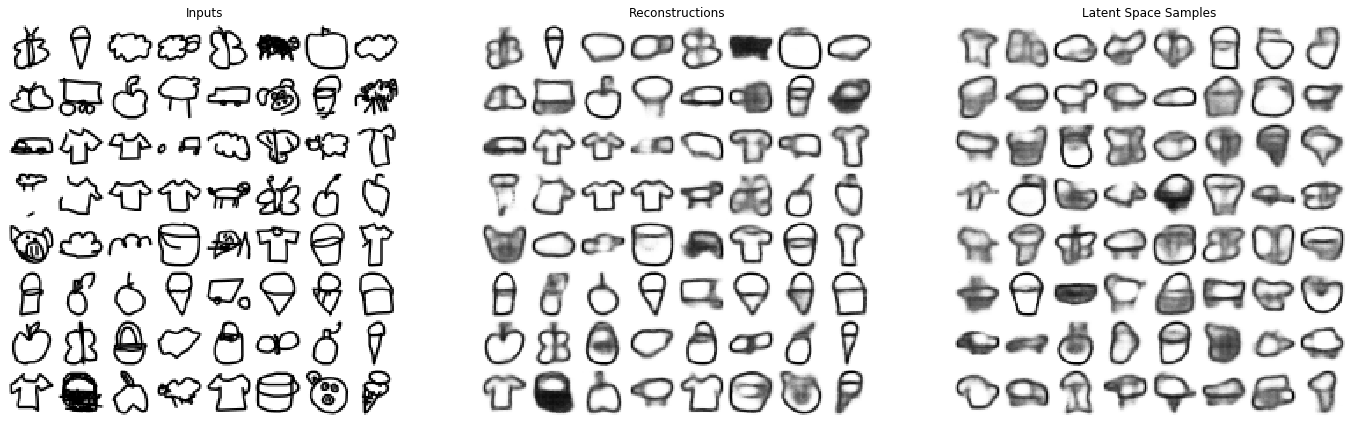

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([16, 784])) that is different to the input size (torch.Size([16, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  


====> Test set loss: 202.1366
Train Epoch: 2 [0/200000 (0%)]	Loss: 199.310165
Train Epoch: 2 [49920/200000 (25%)]	Loss: 195.107422
Train Epoch: 2 [99840/200000 (50%)]	Loss: 202.121140
Train Epoch: 2 [149760/200000 (75%)]	Loss: 193.148346
Train Epoch: 2 [199680/200000 (100%)]	Loss: 183.941833
====> Epoch: 2 Average loss: 199.2302
====> Test set loss: 195.5884
########################################################
Train Epoch: 3 [0/200000 (0%)]	Loss: 192.876511
Train Epoch: 3 [49920/200000 (25%)]	Loss: 195.854218
Train Epoch: 3 [99840/200000 (50%)]	Loss: 195.387161
Train Epoch: 3 [149760/200000 (75%)]	Loss: 192.335236
Train Epoch: 3 [199680/200000 (100%)]	Loss: 192.344788
====> Epoch: 3 Average loss: 193.7260
====> Test set loss: 191.9719
########################################################
Train Epoch: 4 [0/200000 (0%)]	Loss: 188.225342
Train Epoch: 4 [49920/200000 (25%)]	Loss: 188.908188
Train Epoch: 4 [99840/200000 (50%)]	Loss: 189.106613
Train Epoch: 4 [149760/200000 (75%)]	Los

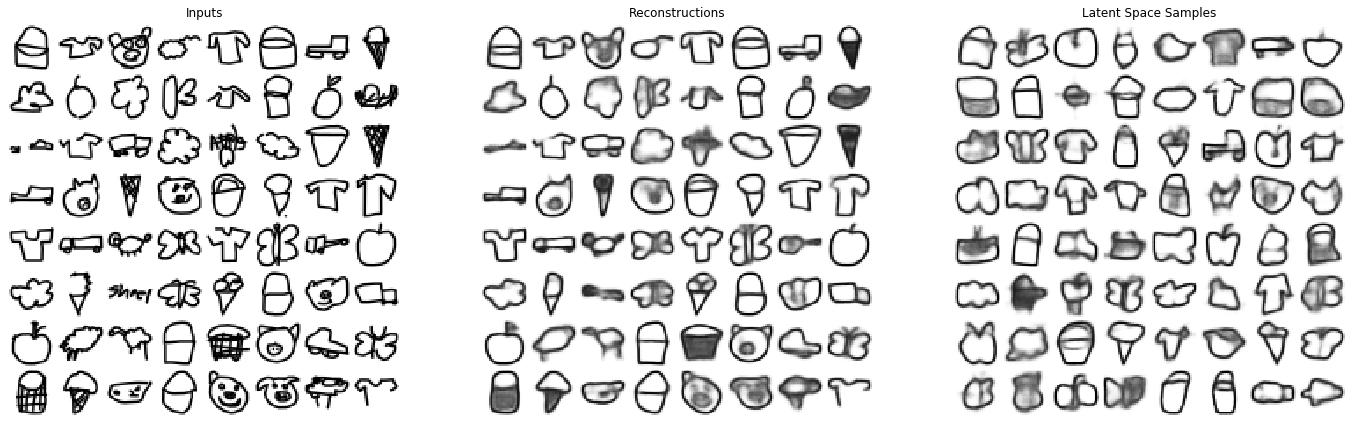

====> Test set loss: 183.6354


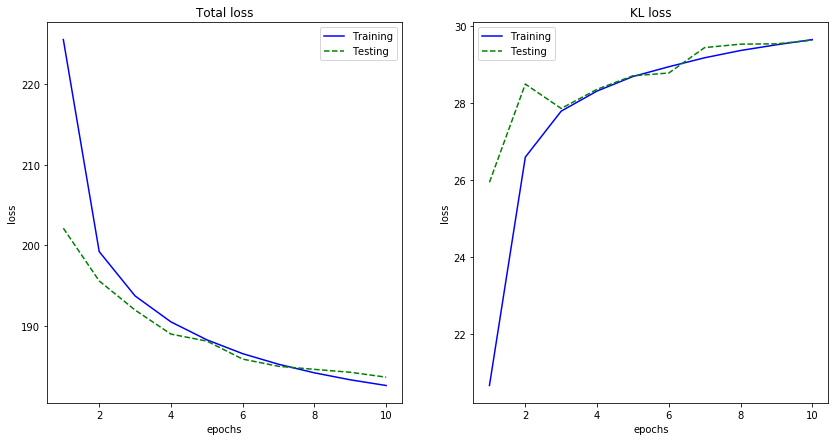

########################################################
Train Epoch: 11 [0/200000 (0%)]	Loss: 183.334244
Train Epoch: 11 [49920/200000 (25%)]	Loss: 176.743088
Train Epoch: 11 [99840/200000 (50%)]	Loss: 164.750183
Train Epoch: 11 [149760/200000 (75%)]	Loss: 188.248764
Train Epoch: 11 [199680/200000 (100%)]	Loss: 177.468155
====> Epoch: 11 Average loss: 182.0473
====> Test set loss: 182.6134
########################################################
Train Epoch: 12 [0/200000 (0%)]	Loss: 187.958160
Train Epoch: 12 [49920/200000 (25%)]	Loss: 179.814606
Train Epoch: 12 [99840/200000 (50%)]	Loss: 172.622971
Train Epoch: 12 [149760/200000 (75%)]	Loss: 165.965454
Train Epoch: 12 [199680/200000 (100%)]	Loss: 186.984009
====> Epoch: 12 Average loss: 181.4852
====> Test set loss: 182.6393
########################################################
Train Epoch: 13 [0/200000 (0%)]	Loss: 169.182343
Train Epoch: 13 [49920/200000 (25%)]	Loss: 191.015686
Train Epoch: 13 [99840/200000 (50%)]	Loss: 181.36285

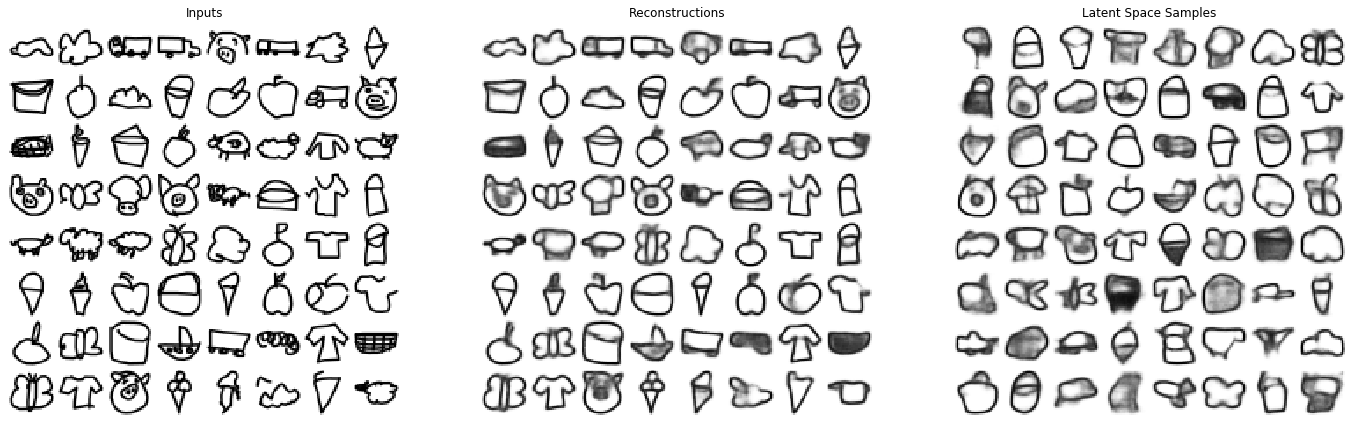

====> Test set loss: 180.6111


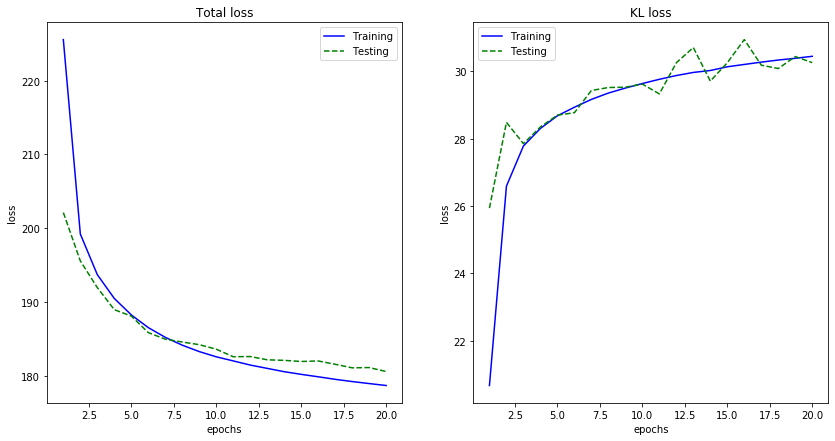

########################################################
Train Epoch: 21 [0/200000 (0%)]	Loss: 173.050507
Train Epoch: 21 [49920/200000 (25%)]	Loss: 173.973785
Train Epoch: 21 [99840/200000 (50%)]	Loss: 171.900421
Train Epoch: 21 [149760/200000 (75%)]	Loss: 176.485031
Train Epoch: 21 [199680/200000 (100%)]	Loss: 179.731049
====> Epoch: 21 Average loss: 178.4470
====> Test set loss: 180.9253
########################################################
Train Epoch: 22 [0/200000 (0%)]	Loss: 170.011185
Train Epoch: 22 [49920/200000 (25%)]	Loss: 198.043976
Train Epoch: 22 [99840/200000 (50%)]	Loss: 182.086090
Train Epoch: 22 [149760/200000 (75%)]	Loss: 181.101303
Train Epoch: 22 [199680/200000 (100%)]	Loss: 181.770050
====> Epoch: 22 Average loss: 178.2417
====> Test set loss: 180.5891
########################################################
Train Epoch: 23 [0/200000 (0%)]	Loss: 175.295929
Train Epoch: 23 [49920/200000 (25%)]	Loss: 175.042496
Train Epoch: 23 [99840/200000 (50%)]	Loss: 178.40133

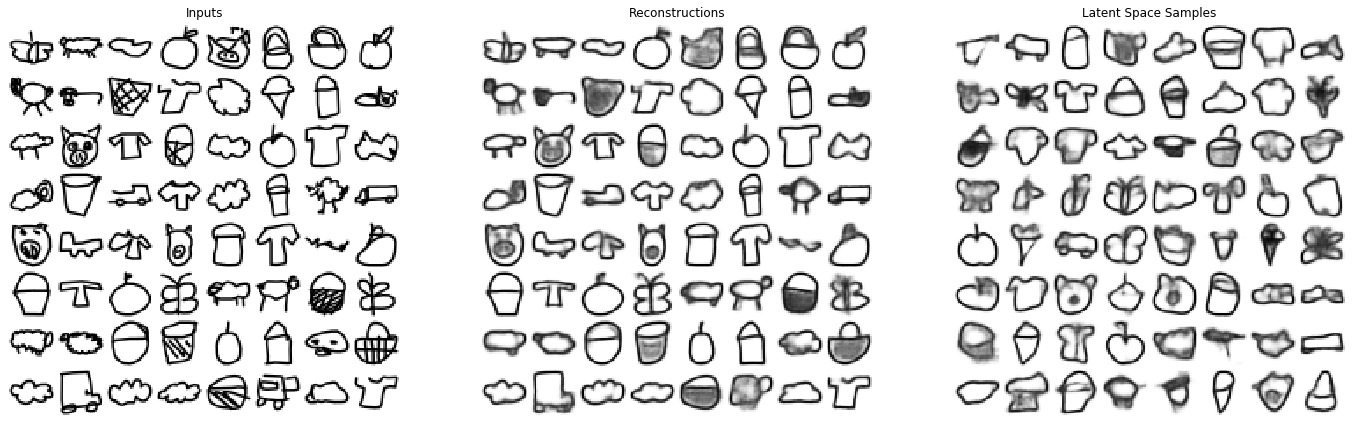

====> Test set loss: 180.3956


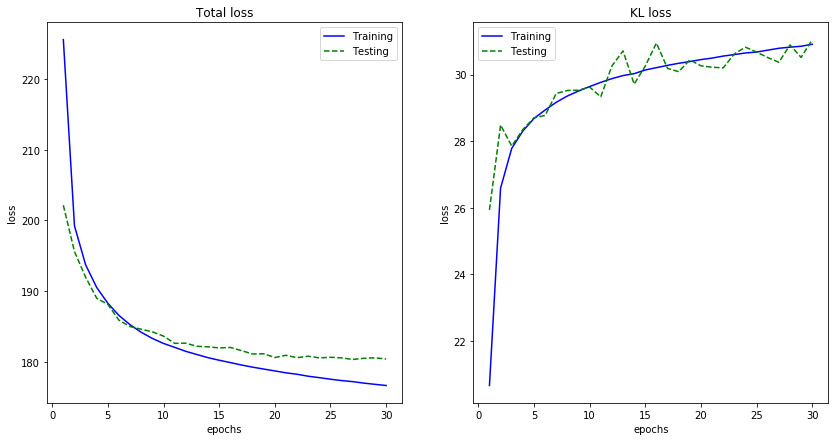

########################################################


In [0]:
model = conv_VAE().to(device) if use_conv else VAE().to(device)
print(f'{"using CNN VAE" if use_conv else "using FC FFNN"}')
print(f'bottleneck: {bottleneck_dim}')

optimizer = optim.Adam(model.parameters(), lr=1e-3)

if __name__ == "__main__":

    epoch_list = []
    epoch_loss_train, epoch_kl_train = [], [] # Train losses per epoch (mean of batch losses)
    epoch_loss_test, epoch_kl_test = [], [] # Test losses per epoch (mean of batch losses)
    
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        
        epoch_list.append(epoch)
        if epoch == 1:
            continue
            
        if epoch % 10 ==0:
            plot_losses(epoch_list, epoch_loss_train, epoch_loss_test, epoch_kl_train, epoch_kl_test)
            
        print("########################################################")

In [0]:
# Save the trained model
now = datetime.now()
current_datetime = now.strftime("%d-%m-%Y_%H-%M-%S")
filepath = os.path.join("gdrive/My Drive/model", f"trained_{current_datetime}.pt")  
torch.save(model.state_dict(), filepath)

# Interpolation

In [0]:
images, labels = next(iter(train_loader))

In [0]:
def interpolate_pair(trn_model, img_from, img_to, img_path, steps, save_img):

  # 1st image
  img_1 = Image.open(os.path.join(img_path, img_from))  # e.g. 'truck_49.png'
  x_from = TF.to_tensor(TF.to_grayscale(img_1))
  x_from = x_from.unsqueeze(0)
  x_from = x_from if use_conv else x_from.view(-1, pixels*pixels)

  # 2nd image
  img_2 = Image.open(os.path.join(img_path, img_to))
  x_to = TF.to_tensor(TF.to_grayscale(img_2))
  x_to = x_to.unsqueeze(0)
  x_to = x_to if use_conv else x_to.view(-1, pixels*pixels)

  interpolate_images(trn_model, x_from, x_to, steps, save_img)

In [0]:
def interpolate(trn_model, images, idx_from, idx_to, steps, save_img):

    # get input images
    x_from = images[idx_from].unsqueeze(0)
    x_to = images[idx_to].unsqueeze(0)

    x_from = x_from if use_conv else x_from.view(-1, pixels*pixels)
    x_to = x_to if use_conv else x_to.view(-1, pixels*pixels)

    interpolate_images(trn_model, x_from, x_to, steps, save_img)


def interpolate_images(trn_model, img_from, img_to, steps, save_img):

    # get latent space representations of input images
    latent_from = trn_model.reparametrize(*trn_model.encode(img_from.to(device)))
    latent_to = trn_model.reparametrize(*trn_model.encode(img_to.to(device)))

    # actual steps including original images
    n = steps + 1 

    # initialize interpolation vector)
    inter = torch.zeros((n, latent_from.shape[1])).to(device)

    with torch.no_grad():
        alphaValues = np.linspace(0, 1, steps + 1)
        
        for i in range(n):
            alpha = alphaValues[i]
            inter[i] = latent_from * alpha + (1-alpha) * latent_to
        
        output = trn_model.decode(inter).cpu()
        plot_interpolated_images(output, save_img)

In [13]:
# Load the model for inference

# filepath = "gdrive/My Drive/model/trained_30-11-2019_17-11-34.pt"    # CNN
filepath = "gdrive/My Drive/model/trained_29-12-2019_17-17-19.pt"    # CNN
# filepath = "gdrive/My Drive/model/trained_02-12-2019_11-01-46.pt"  # FC FFNN
trn_model = conv_VAE().to(device) if use_conv else VAE().to(device)
trn_model.load_state_dict(torch.load(filepath))
trn_model.eval()
print(f'{"using CNN VAE" if use_conv else "using FC FFNN"}')

using CNN VAE


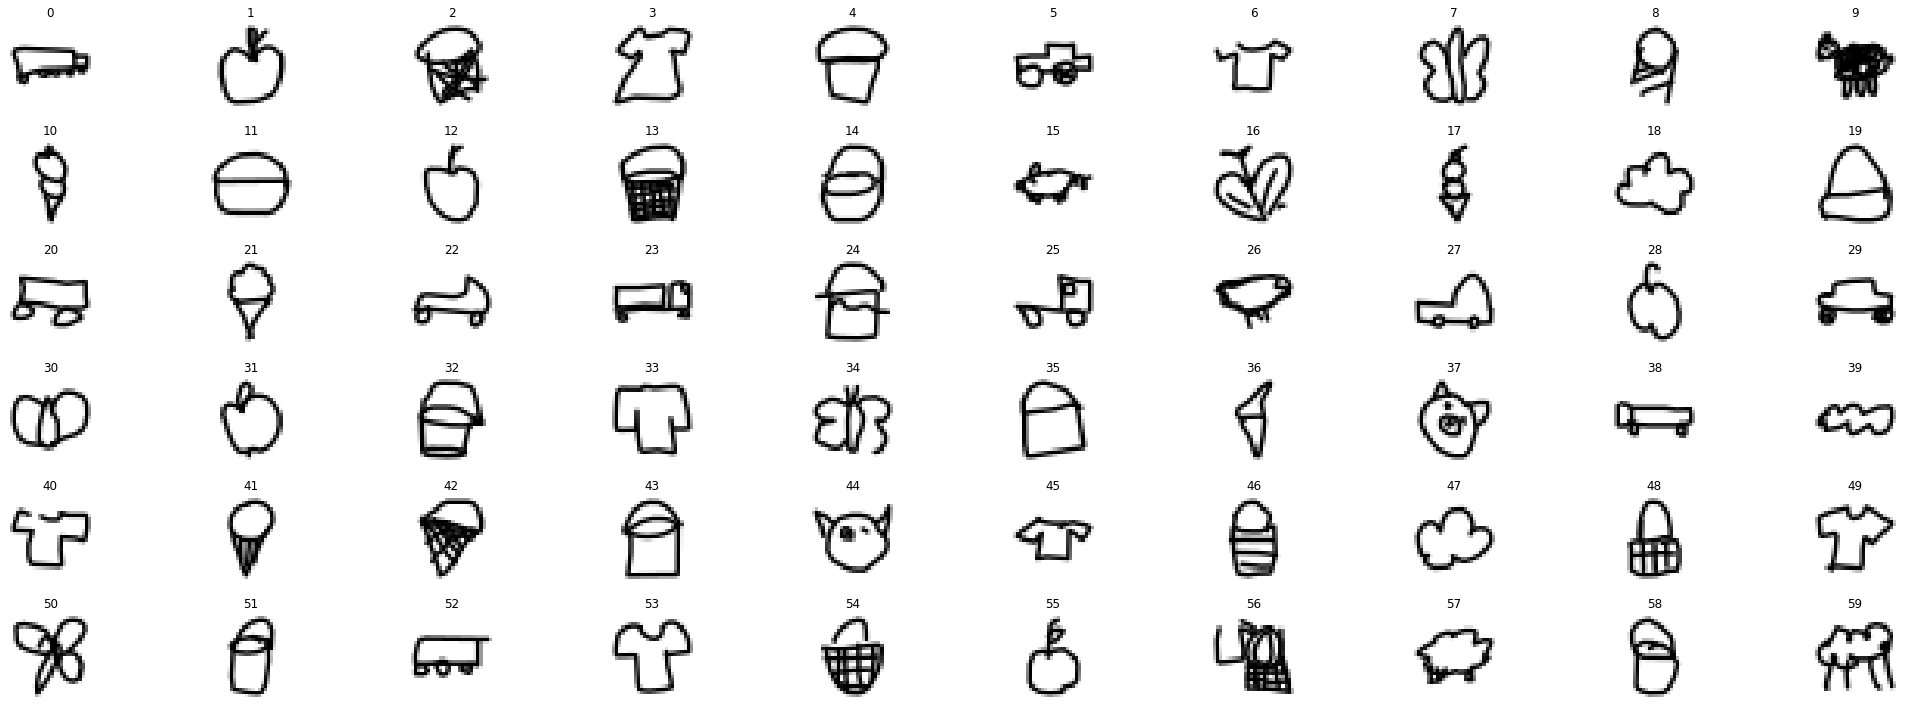

In [14]:
# Show possible images for interpolation
f, axarr = plt.subplots(6, 10, figsize=(28, 10))
f.tight_layout()

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.title.set_text(i)
    ax.axis('off')
    
plt.show()

In [0]:
# Save indexed images  
i=22
img_path = "gdrive/My Drive/gif"
save_image(images[i], os.path.join(img_path, f"truck_{i}.png"))

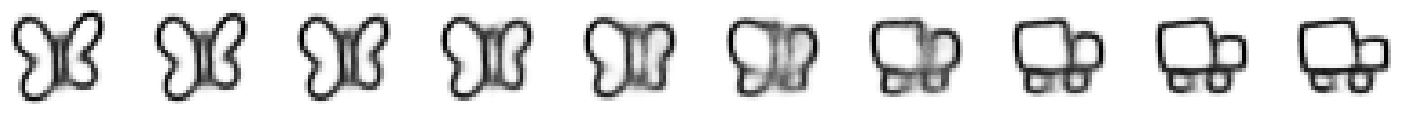

In [36]:
# Interpolation from the saved images
STEPS = 9
IMG_FROM = 'truck_49.png'
IMG_TO = 'butterfly_14.png'
save_img = True

interpolate_pair(trn_model, IMG_FROM, IMG_TO, img_path, STEPS, save_img) 

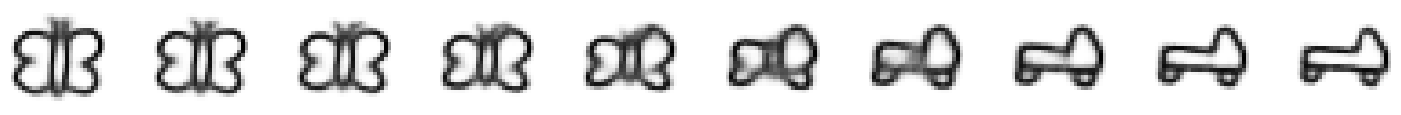

In [25]:
# Interpolation from the indexed images displayed above
STEPS = 9
INDEX_FROM = 22
INDEX_TO = 34
save_img = False

interpolate(trn_model, images, INDEX_FROM, INDEX_TO, STEPS, save_img)

# Latent space visualization

In [0]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

def encode_all(model):
    all_input_vectors, tmp_input_vectors = [],[]
    all_latent_vectors, all_labels = [],[]
    tmp_vectors, tmp_labels = [], []
    
    batch_counter = 0
    
    for batch, labels in train_loader:
        
        # comment out the line below to encode all training data
        if batch_counter == 300:
            break
        
        for image in batch:
            image = image if use_conv else image.view(-1, pixels*pixels)
            image.unsqueeze_(0)
            latent_vector = model.reparametrize(*model.encode(image.to(device)))
            
            tmp_vectors.append(latent_vector.unsqueeze(0))
            tmp_input_vectors.append(image)

        tmp_labels.append(labels)
        batch_counter += 1

    latent_vectors = torch.cat(tmp_vectors)
    input_vectors = torch.cat(tmp_input_vectors)
    all_labels = torch.cat(tmp_labels)

    return latent_vectors, all_labels, input_vectors

def plot_tsne_dots(data_encoded, labels):
    with torch.no_grad():
        data_encoded.squeeze_()
        data_embedded = TSNE(n_components=2).fit_transform(data_encoded.cpu())

        palette = sns.color_palette("Paired", labels.unique().shape[0])
        plt.figure(figsize=(16, 14))
        sns.scatterplot(data_embedded[:,0], data_embedded[:,1], hue=labels, legend='full', palette = palette)

            
def plot_tsne_images(data_encoded, input_images, labels):
    with torch.no_grad():
        data_encoded.squeeze_()
        data_embedded = TSNE(n_components=2).fit_transform(data_encoded.cpu())

        fig, ax = plt.subplots(figsize=(16,14))
        ax.scatter(data_embedded[:,0], data_embedded[:,1],c=labels, cmap='Paired')

        for x, y, image in zip(data_embedded[:,0], data_embedded[:,1], input_images):
            image = image.reshape(28, 28)
            ab = AnnotationBbox(OffsetImage(image.squeeze(), cmap="binary_r"), (x, y), frameon=False)
            ax.add_artist(ab)


In [0]:
data_encoded, labels, inputs = encode_all(trn_model)
print(data_encoded.shape)
print(inputs.shape)

torch.Size([19200, 1, 32])
torch.Size([19200, 1, 28, 28])


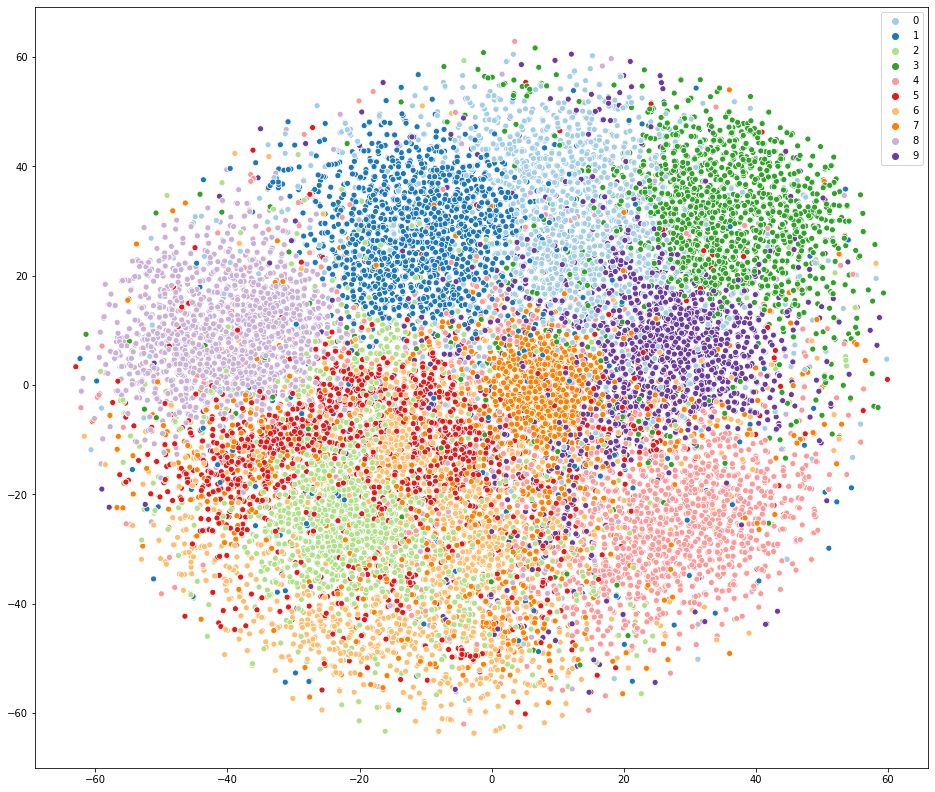

In [0]:
plot_tsne_dots(data_encoded, labels)

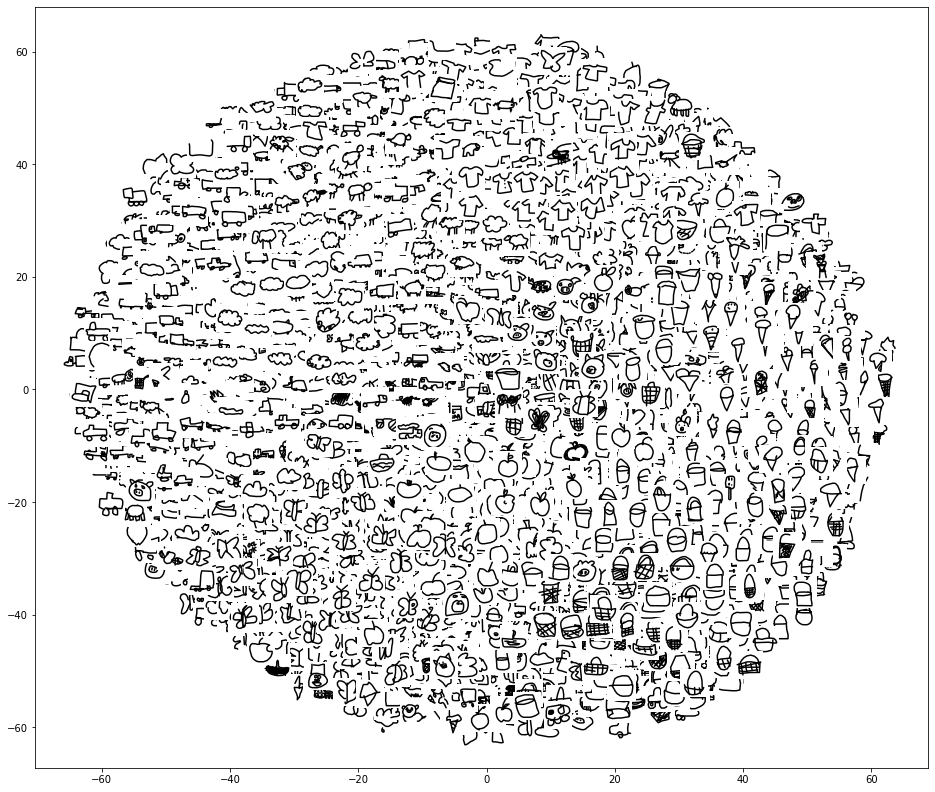

In [0]:
plot_tsne_images(data_encoded, inputs, labels)

In [0]:
def modified_brownian_motion(dim, n_steps=1000, alpha=0.5):
    """
    params:
        dim:        Dimensionality of the space the Brownian motion process
        n_steps:    Int representing the number of steps the Brownian motion
                    process will run for.
        delta_t:    Float representing time discretization. 
                    Should be sufficiently small
        alpha:      Interpolation coefficient. Should be in (0, 1).
    """
    delta_t = 1/n_steps
    samples = torch.zeros([n_steps, dim])
    samples[0] = torch.randn([dim])

    for i in range(1, n_steps):
      samples[i] = samples[i-1] + np.sqrt(delta_t) * torch.randn([dim])
      # samples[i] = (1-alpha) *samples[i-1] + alpha * torch.randn([dim])
    return samples

In [0]:
N = 1000
samples = modified_brownian_motion(bottleneck_dim, n_steps=N, alpha=0.5)
dir_random_walk = "gdrive/My Drive/random_walk"

with torch.no_grad():
  for j in range(N):
    sample = trn_model.decode(samples[j].cuda())
    save_image(sample.view(28, 28), os.path.join(dir_random_walk, f"img_{j}.png"))